## Capstone project tensorflow probability course

In [73]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tqdm import tqdm

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D, 
                                     UpSampling2D, BatchNormalization)

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline


In [74]:
sample = tf.random.normal(shape = (5000, 2), stddev=0.3)

In [75]:
f1 = tfb.Shift((0., -2.))
f2 = tfb.Scale((1., 0.5))

In [76]:
class f3_class(tfb.Bijector):

    
    def __init__(self, a, validate_args=False):
        super().__init__(
        validate_args=validate_args,
        forward_min_event_ndims=1,
        inverse_min_event_ndims=1,
        name='f3_class',
        is_constant_jacobian=True
        )
        self.a = tf.cast(a, tf.float32)
        self.event_ndim = 1

    def _forward(self, x):
        batch_ndim = len(x.shape) - self.event_ndim
        x = tf.cast(x, tf.float32)
        x0 = tf.expand_dims(x[..., 0], batch_ndim)
        x1 = tf.expand_dims(x[..., 1], batch_ndim)
        y0 = x0
        y1 = x1 + ((x0**2) * self.a)
        return tf.concat((y0, y1), axis=-1)
    
    def _inverse(self, y):
        batch_ndim = len(y.shape) - self.event_ndim
        y = tf.cast(y, tf.float32)
        y0 = tf.expand_dims(y[..., 0], batch_ndim)
        y1 = tf.expand_dims(y[..., 1], batch_ndim)
        x0 = y0
        x1 = y1 - ((x0**2) * self.a)
        return tf.concat((x0, x1), axis=-1)
    
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)
        

In [77]:
class f4_class(tfb.Bijector):
    def __init__(self, theta, validate_args=False):
        super().__init__(
          validate_args=validate_args,
          forward_min_event_ndims=1,
          inverse_min_event_ndims=1,
          name='f4_class',
          is_constant_jacobian=True
        )

        self.cos_theta = tf.math.cos(theta)
        self.sin_theta = tf.math.sin(theta)
        self.event_ndim = 1

    def _forward(self, x):
        batch_ndim = len(x.shape) - self.event_ndim
        x0 = tf.expand_dims(x[..., 0], batch_ndim)
        x1 = tf.expand_dims(x[..., 1], batch_ndim)
        y0 = self.cos_theta * x0 - self.sin_theta * x1
        y1 = self.sin_theta * x0 + self.cos_theta * x1
        return tf.concat((y0, y1), axis=-1)

    def _inverse(self, y):
        batch_ndim = len(y.shape) - self.event_ndim
        y0 = tf.expand_dims(y[..., 0], batch_ndim)
        y1 = tf.expand_dims(y[..., 1], batch_ndim)
        x0 = self.cos_theta * y0 + self.sin_theta * y1
        x1 = -self.sin_theta * y0 + self.cos_theta * y1
        return tf.concat((x0, x1), axis=-1)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

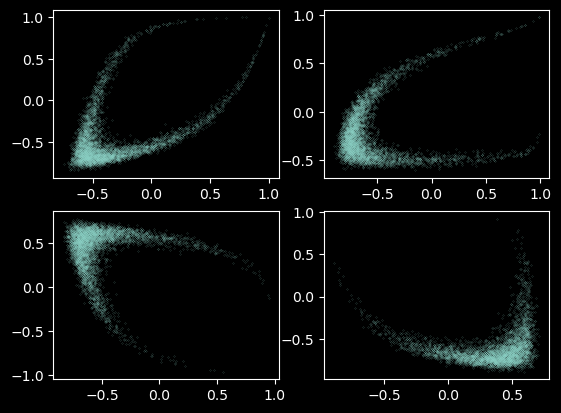

In [78]:
for i in range(4):
    a = tf.random.normal(shape = (1, ), mean = 3, stddev= 1)
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)

    f1 = tfb.Shift((0., -2.))
    f2 = tfb.Scale((1., 0.5))
    f3 = f3_class(a)
    f4 = f4_class(theta)
    f5 = tfp.bijectors.Tanh()
    transformation = tfb.Chain([f5, f4, f3, f2, f1])
    distribution = tfd.TransformedDistribution(tfd.MultivariateNormalDiag(loc = [[0, 0]] , scale_diag= [[0.3, 0.3]]), bijector = transformation)
    plt.subplot(2, 2, i + 1)
    plt.scatter(*distribution.sample(5000).numpy().T, s = 0.01)

In [79]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2)).numpy()
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    Z[np.isnan(Z)] = 0
    return Z.squeeze()

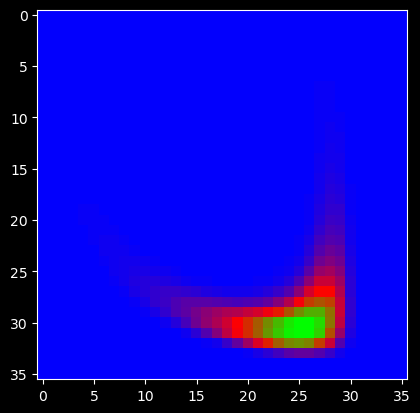

In [80]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z, heatmap, size= 0.36):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(size, size))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap= heatmap, levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot
plt.imshow(get_image_array_from_density_values(get_densities(distribution), heatmap= 'brg'))

In [81]:
def generate_distribution(a, theta):

    #Bijectors
    f1 = tfb.Shift((0., -2.))
    f2 = tfb.Scale((1., 0.5))
    f3 = f3_class(a)
    f4 = f4_class(theta)
    f5 = tfp.bijectors.Tanh()
    transformation = tfb.Chain([f5, f4, f3, f2, f1])
    # Distribution
    distribution = tfd.TransformedDistribution(
        tfd.MultivariateNormalDiag( loc = [[0, 0]],
                                    scale_diag= [[0.3, 0.3]]),
                                     bijector = transformation)
    return distribution

/tmp/ipykernel_41419/2751873433.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


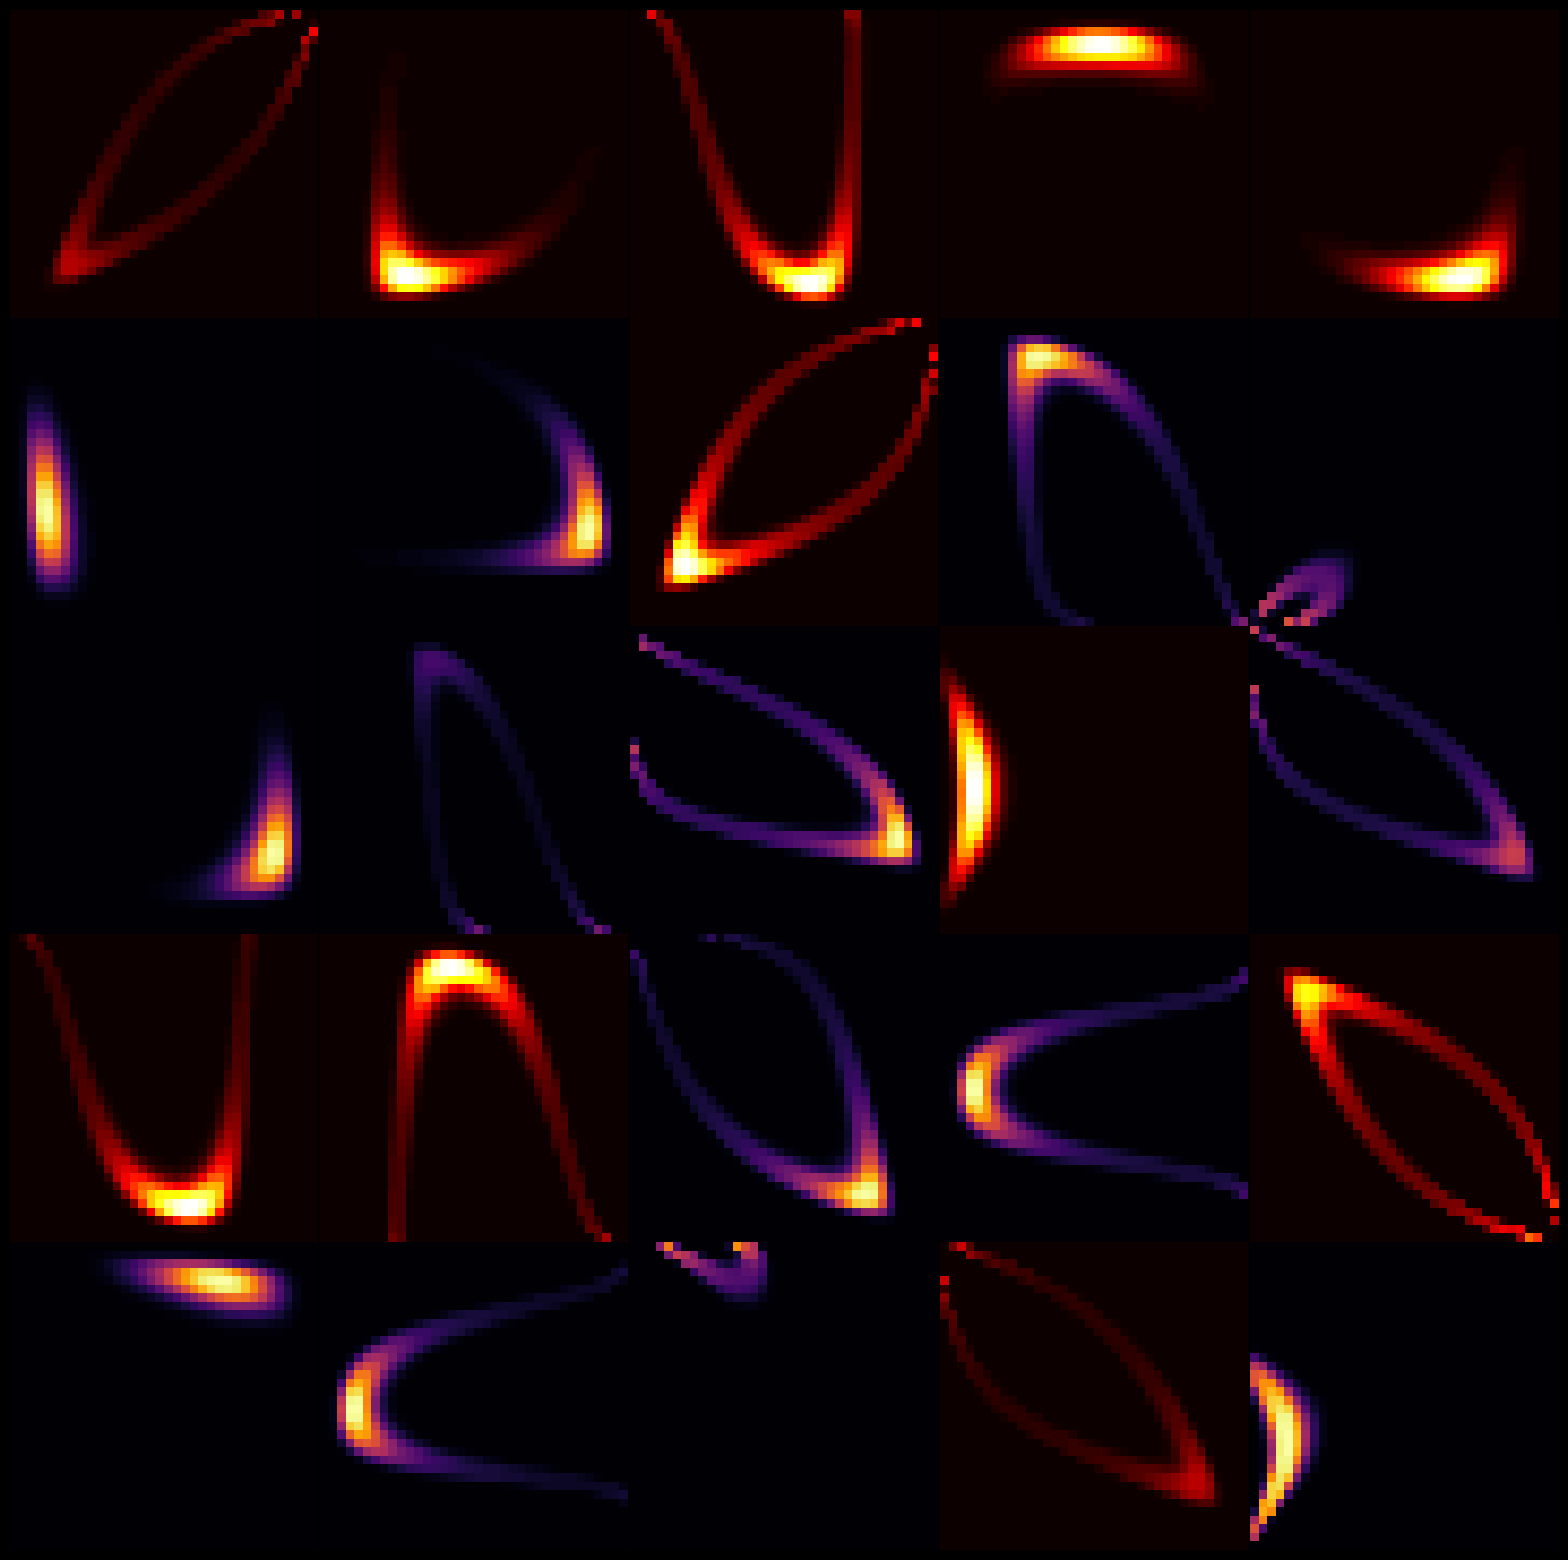

In [82]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])
heatmap = ['inferno', 'hot', 'nipy_spectral']
plt.style.use('dark_background')
plt.figure(figsize=(20, 20))
for i in range(25):
    
    heatmap_index = np.random.randint(0, 2)
    a = tf.random.normal(shape = (1, ),
                        mean = np.random.normal(3, 0.7, size = 1),
                        stddev= np.random.lognormal(1, 0.5, size = 1))
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)
    my_distri = generate_distribution(a, theta)
    plt.subplot(5, 5, i + 1)
    plt.imshow(get_image_array_from_density_values(get_densities(my_distri),
                                                   heatmap = heatmap[heatmap_index]))
    plt.grid(b=None)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [121]:
my_images = []
for i in tqdm(range(1000*10)):
    heatmap_index = np.random.randint(0, 2)
    a = tf.random.normal(shape = (1, ),
                        mean = np.random.normal(3, 0.7, size = 1),
                        stddev= np.random.lognormal(1, 0.5, size = 1))
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)
    my_distri = generate_distribution(a, theta)
    my_images.append(get_image_array_from_density_values(get_densities(my_distri),
                                                   heatmap = heatmap[heatmap_index]))

my_images = np.array(my_images)
print(my_images.shape)
np.save('weird_dataset.npy', my_images)

100%|██████████| 10000/10000 [22:19<00:00,  7.47it/s]


(10000, 36, 36, 3)


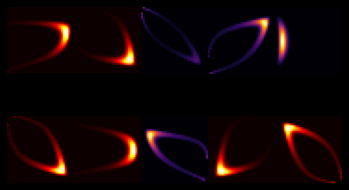

In [118]:
for i, image in enumerate(my_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.grid(b=None)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [93]:
# Load data and generate tf.data.Datasets
train_data = np.load("Data/weird_dataset.npy")
train_data = tf.data.Dataset.from_tensor_slices(train_data)
train_data = train_data.map(lambda x: x/255)
train_data = train_data.map(lambda x: (x, x))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset.element_spec

(TensorSpec(shape=(None, 36, 36, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 36, 36, 3), dtype=tf.float32, name=None))

In [84]:
## Build the model!
# The prior distribution should be a zero-mean,
# isotropic Gaussian (identity covariance matrix).

def get_encoder(latent_dim, kl_regularizer):

    model = Sequential(
        [Conv2D(36, 4, 2, 'SAME',
               input_shape = (36, 36, 3),
               activation = 'elu',
               name = 'e1'),
         BatchNormalization(),
         Conv2D(36, 4, 2, 'SAME',
                activation = 'elu', name = 'e2'),
         BatchNormalization(),
         Conv2D(72, 4, 2, 'SAME',
                activation = 'elu', name = 'e3'),
         BatchNormalization(),
         Conv2D(144, 4, 2, 'SAME',
                activation = 'elu', name = 'e4'),
         BatchNormalization(),
         Flatten(),
         Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
         tfpl.MultivariateNormalTriL(latent_dim,
                                    activity_regularizer = kl_regularizer)
                       ])
                        
    return model

def get_decoder(latent_dim):
    model = Sequential(
        [Dense(4050, input_shape = (latent_dim, ), activation = 'elu', name = 'd1'),
         Reshape((9, 9, 50)),
         #UpSampling2D(2),
         Conv2D(72, 3, activation = 'elu', padding = 'SAME', name = 'd2'),
         UpSampling2D(2),
         Conv2D(36, 3, activation = 'elu', padding = 'SAME', name = 'd3'),
         #UpSampling2D(2),
         Conv2D(36, 3, activation = 'elu', padding = 'SAME', name = 'd4'),
         UpSampling2D(2),
         Conv2D(72, 3, activation = 'elu', padding = 'SAME', name = 'd5'),
         Conv2D(3, 3, activation = 'linear', padding = 'SAME', name = 'd6'),
         Flatten(),
         tfpl.IndependentBernoulli(event_shape = (36, 36, 3))
        ])
                        
    return model


In [85]:
def get_prior(latent_dim):

    prior = tfd.MultivariateNormalDiag(
                loc=tf.zeros([latent_dim]),
                scale_diag=tf.ones([latent_dim])
                )

    return prior

def get_kl_regularizer(prior_distribution):
    reg = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        test_points_fn = lambda q: q.sample(10)) # MC approximation 10
                                                 # samples
    return reg

def reconstruction_loss(batch_of_images, decoding_dist):
    # This works because the decoder outputs
    # a probability distribution!
    return -tf.math.reduce_mean(decoding_dist.log_prob(batch_of_images))

In [86]:
LATENT_DIM = 50
prior = get_prior(LATENT_DIM)
regularizer = get_kl_regularizer(prior)

encoder = get_encoder(LATENT_DIM, regularizer)
decoder = get_decoder(LATENT_DIM)

In [87]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [88]:
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e1_input (InputLayer)       [(None, 36, 36, 3)]       0         
                                                                 
 e1 (Conv2D)                 (None, 18, 18, 36)        1764      
                                                                 
 batch_normalization_20 (Bat  (None, 18, 18, 36)       144       
 chNormalization)                                                
                                                                 
 e2 (Conv2D)                 (None, 9, 9, 36)          20772     
                                                                 
 batch_normalization_21 (Bat  (None, 9, 9, 36)         144       
 chNormalization)                                                
                                                                 
 e3 (Conv2D)                 (None, 5, 5, 72)          4154

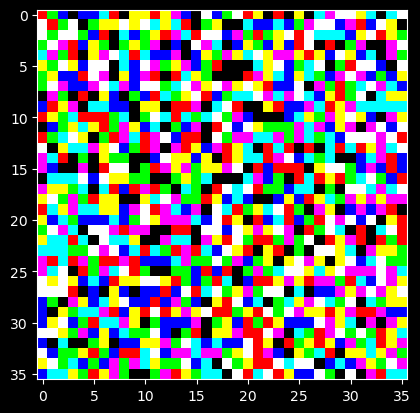

In [89]:
plt.imshow(vae(np.random.uniform(0, 1, size = (1, 36, 36, 3))).sample(1)[0][0])

In [90]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [94]:
# Generate some validation data;
my_images_val = []
for i in tqdm(range(1000)):
    heatmap_index = np.random.randint(0, 2)
    a = tf.random.normal(shape = (1, ),
                        mean = np.random.normal(3, 0.7, size = 1),
                        stddev= np.random.lognormal(1, 0.5, size = 1))
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)
    my_distri = generate_distribution(a, theta)
    my_images_val.append(get_image_array_from_density_values(get_densities(my_distri),
                                                   heatmap = heatmap[heatmap_index]))

my_images_val = np.array(my_images_val)
print(my_images_val.shape)
np.save('Data/weird_dataset_val.npy', my_images_val)

val_data = np.load("Data/weird_dataset_val.npy")
val_data = tf.data.Dataset.from_tensor_slices(val_data)
val_data = train_data.map(lambda x: x/255)
val_data = train_data.map(lambda x: (x, x))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

val_data = val_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data.element_spec

 14%|█████▍                                  | 135/1000 [00:12<01:23, 10.40it/s]


KeyboardInterrupt: 

In [96]:
val_data = np.load("Data/weird_dataset_val.npy")
val_data = tf.data.Dataset.from_tensor_slices(val_data)
val_data = val_data.map(lambda x: x/255)
val_data = val_data.map(lambda x: (x, x))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

val_data = val_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data.element_spec

(TensorSpec(shape=(None, 36, 36, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 36, 36, 3), dtype=tf.float32, name=None))

In [97]:
vae.fit(train_dataset, validation_data=val_data, epochs=1)

 64/313 [=====>........................] - ETA: 48s - loss: 3457.7871

KeyboardInterrupt: 

## TODO: Create tf.dataset, write the VAE architecture, train it, and interpolate.
# Plus translate the differential equations stuff to tf (diffusion probabilistic modelling) and try it out in this dataset.